# CS7643 Final Project

This notebook is meant to go through the different models and experiment on our dataset containing 21782 training samples on different sounds. 

## Group Members
Zach Halaby
Michael Marzec
Shayan Mukhtar

## Dataset

The dataset was obtained under Google's GPL license terms from the following site: https://research.google.com/audioset/download.html

## Colab Prep

github <--> colab instructions: https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

In [1]:
### If using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Initial Cloning

In [ ]:
### cd to github drive (create the folder, if it doesn't already exist)
%cd /content/drive/MyDrive/Github

# git clone -b branch https://{git_token}@github.com/{username}/{repository}
# See instructions file if you're unfamiliar with generating git_tokens

username = 'shayanmukhtar'
repository = 'cs7643_final'
# git_token = 

# !git clone -b UPDATE_BRANCH https://{git_token}@github.com/{username}/{repository}



### Git Commands

#### access git (via Google Drive)

In [2]:
%cd /content/drive/MyDrive/Github

repository = 'cs7643_final'
%cd {repository}

%ls -a

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/cs7643_final
cs7643_final_project.ipynb  main_scratch.py  plots/     utils/
.git/                       models/          README.md


#### Commit / Status / Push

In [ ]:
!git status

On branch marzec
Your branch is up to date with 'origin/marzec'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   cs7643_final_project.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add .

In [ ]:
# !git config user.email "michaelmarzec11@gmail.com"
!git commit -m "conv loss plots"

[marzec 8b6c460] conv loss plots
 13 files changed, 1 insertion(+), 1 deletion(-)
 delete mode 100644 plots/conv_lossPlot_16_0.0001_3_0.1.png
 delete mode 100644 plots/conv_lossPlot_16_0.0001_3_0.4.png
 delete mode 100644 plots/conv_lossPlot_32_0.0001_3_0.4.png
 delete mode 100644 plots/conv_lossPlot_32_0.001_3_0.01.png
 delete mode 100644 plots/conv_lossPlot_32_0.001_3_0.1.png
 delete mode 100644 plots/conv_lossPlot_32_0.001_3_0.4.png
 delete mode 100644 plots/conv_lossPlot_32_0.001_3_0.6.png
 delete mode 100644 plots/conv_lossPlot_64_0.0001_3_0.3.png
 delete mode 100644 plots/conv_lossPlot_64_0.01_3_0.1.png
 delete mode 100644 plots/conv_lossPlot_64_0.01_3_0.3.png
 delete mode 100644 plots/conv_lossPlot_8_0.001_3_0.1.png
 delete mode 100644 plots/conv_lossPlot_8_0.001_3_0.3.png


In [ ]:
!git push

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.03 KiB | 526.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/shayanmukhtar/cs7643_final
   2a029aa..8b6c460  marzec -> marzec


## Instructions
Cells with a "Mandatory" in their title must be run. Cells with a title stating that running is optional do not have to be run.

## Mandatory - Imports

Let's start by importing the necessary packages:

In [3]:
!pip install torchmetrics
!pip install tfrecord

import os.path

import torch
import torchmetrics
import tfrecord
import numpy as np
from os import walk
import matplotlib.pyplot as plt

from torchmetrics import ConfusionMatrix
from torchmetrics import F1

from torch.utils.data import DataLoader

from models import LinearModel
from models import SimpleConvolutionModel
from models import SimpleRecurrentModel
from utils import utils
from utils import dataloader
from torch import nn
from torch import optim

# Tqdm progress bar
from tqdm import tqdm_notebook

     |████████████████████████████████| 332 kB 16.4 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
  Created wheel for tfrecord: filename=tfrecord-1.14.1-py3-none-any.whl size=15654 sha256=1ccf082d9d7218da227ab34ef8ef9334432585a4d21c37d90de2113d8e40d36b
  Stored in directory: /root/.cache/pip/wheels/07/63/59/2a382bd2e3051f622bf8742e79f2641d78b29523680f57bf74
Successfully built tfrecord


## Mandatory - Load Training Data

Load the training data into memory

In [4]:
# Figure out which device this notebook is being run from
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

# Load the training data from memory. Note this training data was created
# by converting the tfrecord files from the original dataset
training_data = utils.load_pytorch_tensor('./utils/balanced_train_data.pt')
training_label = utils.load_pytorch_tensor('./utils/balanced_train_label.pt')

# make this multi-classification problem a binary classification problem by
# selecting all labels which contain a given class and making their label
# True, and all others False. In this case, 0 means select the speech class
training_label, count = utils.convert_multiclass_to_binary(0, training_label)
print("Total of " + str(count) + " positive examples out of " + str(training_label.shape[0]) + " samples")

# convert the training data to floating point
training_data = np.float32(training_data)

# split the training data into two parts, one for training and the other for validation
data_train, label_train, data_val, label_val = utils.split_data_train_val(training_data, training_label)

# put on the right device
data_train = torch.from_numpy(data_train).to(device)
label_train = torch.from_numpy(label_train).to(device)
data_val = torch.from_numpy(data_val).to(device)
label_val = torch.from_numpy(label_val).to(device)

# Load the dataset into an iterable object from which batches can be made
train_dataset = dataloader.MusicDataset(data_train, label_train)
val_dataset = dataloader.MusicDataset(data_val, label_val)

You are using device: cuda
Total of 5668 positive examples out of 21782 samples


## Optional - Simple Linear Model

Let's get a training loop running with this simple linear model, which is nothing but an input, a ReLu, and an output

In [ ]:
# Linear Model Hyperparameters

BATCH_SIZE = 16
LEARNING_RATE = .0001
HIDDEN_LAYER_SIZE = 32
NUM_EPOCHS = 30

In [ ]:
# Linear Model boilerplate code

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

linear_model = LinearModel.LinearModel(10*128, HIDDEN_LAYER_SIZE, 2).to(device)
optimizer = optim.Adam(linear_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()

In [ ]:
avg_train_loss_list = []
avg_val_loss_list = []

for epoch_idx in range(NUM_EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, avg_train_loss = utils.train(linear_model, train_loader, optimizer, criterion)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = utils.evaluate(linear_model, val_loader, criterion)

    avg_train_loss = avg_train_loss.item()
    avg_val_loss = avg_val_loss.item()
    print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))

    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)

-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 1.5921. Validation Loss: 0.5167. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.4922. Validation Loss: 0.4656. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.4540. Validation Loss: 0.4404. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.4355. Validation Loss: 0.4254. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.4201. Validation Loss: 0.4219. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.4073. Validation Loss: 0.4109. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3965. Validation Loss: 0.4073. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3894. Validation Loss: 0.4068. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3831. Validation Loss: 0.4124. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3777. Validation Loss: 0.4087. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3727. Validation Loss: 0.4200. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3676. Validation Loss: 0.4066. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3640. Validation Loss: 0.4106. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3601. Validation Loss: 0.4179. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3576. Validation Loss: 0.4147. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3545. Validation Loss: 0.4095. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3488. Validation Loss: 0.4172. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3472. Validation Loss: 0.4109. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3448. Validation Loss: 0.4250. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3438. Validation Loss: 0.4163. 
-----------------------------------
Epoch 21
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3368. Validation Loss: 0.4309. 
-----------------------------------
Epoch 22
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3385. Validation Loss: 0.4652. 
-----------------------------------
Epoch 23
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3328. Validation Loss: 0.4183. 
-----------------------------------
Epoch 24
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3341. Validation Loss: 0.4239. 
-----------------------------------
Epoch 25
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3343. Validation Loss: 0.4310. 
-----------------------------------
Epoch 26
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3264. Validation Loss: 0.4292. 
-----------------------------------
Epoch 27
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3246. Validation Loss: 0.4666. 
-----------------------------------
Epoch 28
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3251. Validation Loss: 0.4382. 
-----------------------------------
Epoch 29
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3226. Validation Loss: 0.4311. 
-----------------------------------
Epoch 30
-----------------------------------


  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Training Loss: 0.3284. Validation Loss: 0.4537. 


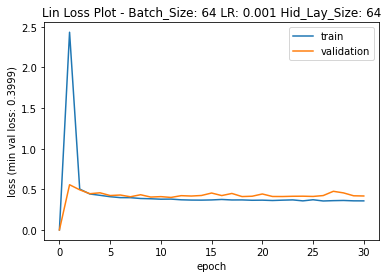

In [ ]:
#fileName
file_name = "plots/linear_lossPlot_" + str(BATCH_SIZE) + "_" + str(LEARNING_RATE) + "_" + str(HIDDEN_LAYER_SIZE) + ".png"
title =  "Lin Loss Plot - Batch_Size: " + str(BATCH_SIZE) + " LR: " + str(LEARNING_RATE) + " Hid_Lay_Size: " + str(HIDDEN_LAYER_SIZE)
min_val_loss = round(min(avg_val_loss_list),4)
y_axis = "loss (min val loss: " + str(min_val_loss) + ")"

#axis/graph prep
avg_train_loss_list.insert(0,0)
avg_val_loss_list.insert(0,0)
x_axis = np.arange(0,(NUM_EPOCHS + 1),1)


plt.plot(x_axis, avg_train_loss_list, label='train')
plt.plot(x_axis, avg_val_loss_list, label='validation')
plt.xlabel('epoch')
plt.ylabel(y_axis)
plt.title(title)
plt.legend()
plt.savefig(file_name)
plt.show();

## Optional - Simple Convolutional Model

Using convolution for sound identification is an established method and has been used on this dataset before. The idea is to make the learnable kernel 1-D and stride it across the sound artifacts. In this simple convolutional model, all 10 seconds of sounds will get flattened into one tensor, and a 1-D kernel strided. 

In [12]:
# Simple Convolution Model Hyperparameters
BATCH_SIZE = 32 # 32
LEARNING_RATE = .001 #.001
NUM_EPOCHS = 40

START_KERNEL_SIZE = 3 # 3
DROPOUT_RATE = 0.2 # 0.2

In [13]:
# Convolution Boilerplate code
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

convolution_model = SimpleConvolutionModel.SimpleConvolutionModel(START_KERNEL_SIZE, DROPOUT_RATE).to(device)
optimizer = optim.Adam(convolution_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()

In [ ]:
avg_train_loss_list = []
avg_val_loss_list = []

for epoch_idx in range(NUM_EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, avg_train_loss = utils.train(convolution_model, train_loader, optimizer, criterion)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = utils.evaluate(convolution_model, val_loader, criterion)

    avg_train_loss = avg_train_loss.item()
    avg_val_loss = avg_val_loss.item()
    print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))

    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)

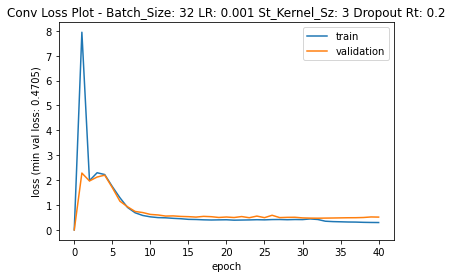

In [15]:
#string prep
file_name = "plots/conv_lossPlot_8layers" + str(BATCH_SIZE) + "_" + str(LEARNING_RATE) + "_" + str(START_KERNEL_SIZE) + "_" + str(DROPOUT_RATE) + ".png"
title =  "Conv Loss Plot - Batch_Size: " + str(BATCH_SIZE) + " LR: " + str(LEARNING_RATE) + " St_Kernel_Sz: " + str(START_KERNEL_SIZE) + " Dropout Rt: " + str(DROPOUT_RATE)
min_val_loss = round(min(avg_val_loss_list),4)
y_axis = "loss (min val loss: " + str(min_val_loss) + ")"

#axis/graph prep
avg_train_loss_list.insert(0,0)
avg_val_loss_list.insert(0,0)
x_axis = np.arange(0,(NUM_EPOCHS + 1),1)


plt.plot(x_axis, avg_train_loss_list, label='train')
plt.plot(x_axis, avg_val_loss_list, label='validation')
plt.xlabel('epoch')
plt.ylabel(y_axis)
plt.title(title)
plt.legend()
plt.savefig(file_name)

plt.show();

## Optional - Simple Recurrent Model

In [ ]:
# Simple Convolution Model Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

In [ ]:
# Convolution Recurrent code
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

recurrent_model = SimpleRecurrentModel.SimpleRecurrentModel(input_size=, output_size=, hidden_dimensions=, n_layers=)).to(device) #####UPDATE PARAMETERS
optimizer = optim.Adam(convolution_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()

In [ ]:
avg_train_loss_list = []
avg_val_loss_list = []

for epoch_idx in range(NUM_EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, avg_train_loss = utils.train(recurrent_model, train_loader, optimizer, criterion)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = utils.evaluate(recurrent_model, val_loader, criterion)

    avg_train_loss = avg_train_loss.item()
    avg_val_loss = avg_val_loss.item()
    print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))

    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)

In [ ]:
#string prep
file_name = "plots/rnn_lossPlot_" + str(BATCH_SIZE) + "_" + str(LEARNING_RATE) + ".png"
title =  "RNN Loss Plot - Batch_Size: " + str(BATCH_SIZE) + " LR: " + str(LEARNING_RATE)
y_axis = "loss (min val loss: " + str(min_val_loss) + ")"

#axis/graph prep
avg_train_loss_list.insert(0,0)
avg_val_loss_list.insert(0,0)
x_axis = np.arange(0,(NUM_EPOCHS + 1),1)


plt.plot(x_axis, avg_train_loss_list, label='train')
plt.plot(x_axis, avg_val_loss_list, label='validation')
plt.xlabel('epoch')
plt.ylabel(y_axis)
plt.title(title)
plt.legend()
plt.savefig(file_name)

plt.show();

## Optional - Model Evaluation

Pick a model that was trained above and push the evaluation data through it, and compute the model metrics

In [ ]:
# First, load the evaluation data
eval_data = utils.load_pytorch_tensor('./utils/eval_data.pt')
eval_label = utils.load_pytorch_tensor('./utils/eval_label.pt')

# make this multi-classification problem a binary classification problem
eval_label, count = utils.convert_multiclass_to_binary(0, eval_label)
print("Total of " + str(count) + " positive examples out of " + str(eval_label.shape[0]) + " samples")

eval_data = np.float32(eval_data)

# put on the right device - for evaluation, we always run from CPU
eval_data = torch.from_numpy(eval_data).to('cpu')
eval_label = torch.from_numpy(eval_label).to('cpu')

# Next, pick the model you want to evaluate
# options: linear_model, convolution_model, recurrent_model 
model = linear_model 

# place the model on the CPU as well
model = model.cpu()

print(eval_data.is_cuda)
print(eval_label.is_cuda)


# push the eval data through the model
eval_dataset = dataloader.MusicDataset(eval_data, eval_label)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)


# declare the metric keepers
conf_mat = ConfusionMatrix(num_classes=2)
f1_score = F1(num_classes=2)
total_accuracy = 0.0

with torch.no_grad():
  # Get the progress bar
  progress_bar = tqdm_notebook(eval_loader, ascii=True)
  for batch_idx, data in enumerate(progress_bar):
      input_data = data[0].to('cpu')
      correct_labels = data[1].to('cpu')

      prediction = model(input_data)

      conf_mat.update(prediction, correct_labels)
      f1_score.update(prediction, correct_labels)
      accuracy = torchmetrics.functional.accuracy(prediction, correct_labels)
      total_accuracy += accuracy
      progress_bar.set_description_str(
          "Batch: %d" % (batch_idx + 1))

# avg_acc, conf_mat, f1_score = utils.evaluate_with_metrics(model, eval_loader)
avg_accuracy = total_accuracy / len(eval_loader)
final_conf_mat = conf_mat.compute()
final_f1_score = f1_score.compute()

print("Model achieved an average accuracy of %.4f on evaluation data" % avg_accuracy.item())
print("Confusion Matrix:")
print(str(final_conf_mat))
print("F1 Score: %.4f" % final_f1_score.item())

Total of 5233 positive examples out of 19976 samples
False
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1249 [00:00<?, ?it/s]

Model achieved an average accuracy of 0.8044 on evaluation data
Confusion Matrix:
tensor([[12796.,  1947.],
        [ 1960.,  3273.]])
F1 Score: 0.8044
